In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, DepthwiseConv2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

C:\Users\amanser\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
base_skin_dir = os.path.join('')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}



# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'ben': 'Benign',
    'mal': 'Malignant'
}

In [4]:
skin_df = pd.read_csv(os.path.join('HAM10000_metadata_binary.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,ben,histo,80.0,male,scalp,input\ISIC_0027419.jpg,Benign,0
1,HAM_0000118,ISIC_0025030,ben,histo,80.0,male,scalp,input\ISIC_0025030.jpg,Benign,0
2,HAM_0002730,ISIC_0026769,ben,histo,80.0,male,scalp,input\ISIC_0026769.jpg,Benign,0
3,HAM_0002730,ISIC_0025661,ben,histo,80.0,male,scalp,input\ISIC_0025661.jpg,Benign,0
4,HAM_0001466,ISIC_0031633,ben,histo,75.0,male,ear,input\ISIC_0031633.jpg,Benign,0


In [5]:
skin_df.isnull().sum()


lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [6]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [7]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


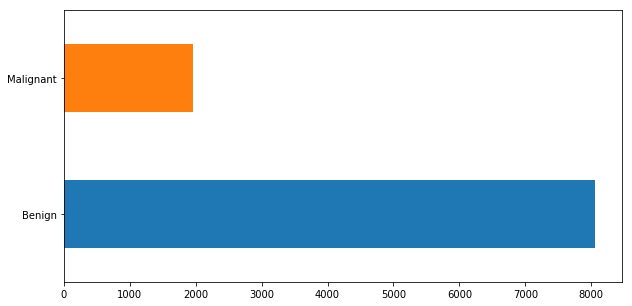

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='barh', ax=ax1)

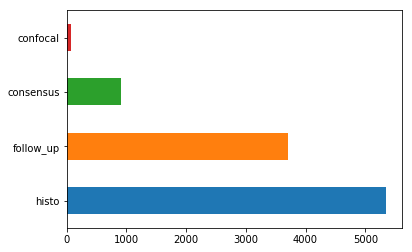

In [9]:
skin_df['dx_type'].value_counts().plot(kind='barh')

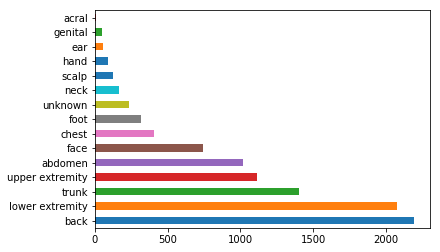

In [10]:
skin_df['localization'].value_counts().plot(kind='barh')

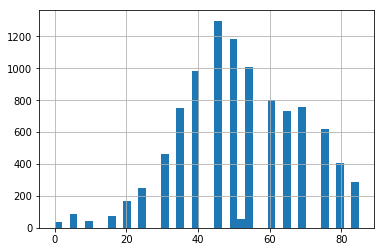

In [11]:
skin_df['age'].hist(bins=40)

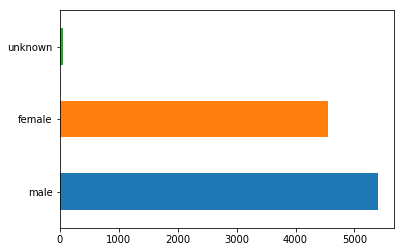

In [12]:
skin_df['sex'].value_counts().plot(kind='barh')

In [13]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [15]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,ben,histo,80.0,male,scalp,input\ISIC_0027419.jpg,Benign,0,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,ben,histo,80.0,male,scalp,input\ISIC_0025030.jpg,Benign,0,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,ben,histo,80.0,male,scalp,input\ISIC_0026769.jpg,Benign,0,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,ben,histo,80.0,male,scalp,input\ISIC_0025661.jpg,Benign,0,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,ben,histo,75.0,male,ear,input\ISIC_0031633.jpg,Benign,0,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [16]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [17]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [18]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=42)

In [19]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [20]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

In [21]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [22]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [23]:
# Set the CNN model 

input_shape = (75, 100, 3)
num_classes = 2

model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(DepthwiseConv2D(16, activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 128)      3584      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 128)      147584    
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 75, 100, 128)      32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [24]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# SGD(lr=0.001, momentum=1e-6, decay=0.7, nesterov=False)

In [25]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [26]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=True, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)


In [ ]:
# Fit the model

# epochs = 50 
# batch_size = 10
# history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_validate,y_validate),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])

In [28]:
from keras.models import load_model

skin_model = load_model("skin_model_binary.h5")

Instructions for updating:
Use tf.cast instead.


In [29]:
loss, accuracy = skin_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = skin_model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))


802/802 [==============================] - 57s 71ms/step
Validation: accuracy = 0.778055  ;  loss_v = 0.528332
Test: accuracy = 0.804294  ;  loss = 0.492775


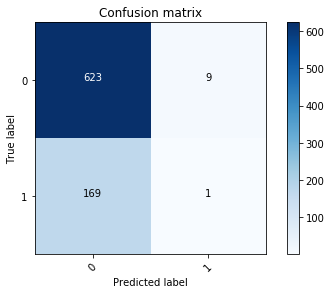

In [30]:
#  Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = skin_model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

### Flask

In [32]:
skin_model.predict

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x000002911DF88438>>

In [33]:
from keras.preprocessing.image import img_to_array
from keras.applications.xception import (
    Xception, preprocess_input, decode_predictions)

def prepare_image(img):
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    # return the processed image
    return img

filepath = os.path.join("Input/ISIC_0024698.jpg")

image_size = (75, 100)

im = keras.preprocessing.image.load_img(filepath,
                                        target_size=image_size,
                                        grayscale=False)

# preprocess the image and prepare it for classification
image = prepare_image(im)

In [60]:
binary_labels = tuple(['Benign','Malignant'])


binary_preds = skin_model.predict(image)


# result_df = pd.DataFrame(columns=['Label',"Prediction"])

# for x,y in zip(preds[0],binary_labels):
    
#     result_df = result_df.append({'Label': y, 'Prediction': str(round(x*100, 4)) + "%"}, ignore_index=True)
    
# result_df

print (binary_preds)

[[0.38332477 0.61667526]]


In [62]:
# labels = ('Melanocytic nevi','Melanoma','Benign keratosis-like lesions', 'Basal cell carcinoma',
#     'Actinic keratoses','Vascular lesions','Dermatofibroma')

# preds = [0.6127, 0.7422, 0.000000513, 0.000000513, 0.000000513, 0.000000513, 0.000000513 ]



updated_binary_preds = list(map(lambda x : (round(x*100,4)), binary_preds[0]))


lesion_list = list(zip(binary_labels, updated_binary_preds))


print(f"""
The uploaded lesion has a predicted malignancy of {updated_binary_preds[1]}%

""")


The uploaded lesion has a predicted malignancy of 61.6675%


